In [1]:
import pandas as pd
import numpy as np
import anndata as ad
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import pybedtools
import dask
import pathlib
from ALLCools.api import *
from ALLCools.mcds import MCDS
from ALLCools.clustering import one_vs_rest_dmg,tsne, significant_pc_test, log_scale, cluster_enriched_features,balanced_pca
from ALLCools.plot import *
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# import xarray
# print(xarray.__file__)


Matplotlib is building the font cache; this may take a moment.


# multi batch

In [2]:
### Parameter

CZIOI='CZIall'
output_dir='/datasets/CZI_human_diversity/NOVAseq_hisat/'
metadata_path ='/datasets/CZI_human_diversity/NOVAseq_hisat/CZIall_CellMetadata.PassQC.csv.gz'

# change this to the paths to your MCDS files, 
# ALLCools.MCDS can handle multiple MCDS files automatically
mcds_path_list =glob.glob('/datasets/CZI_human_diversity/NOVAseq_hisat/mcds/*.mcds/')    

# Dimension name used to do clustering
# This corresponding to AnnData .obs and .var
obs_dim = 'cell'  # observation
var_dim = 'chrom100k'  # feature

# Regions to remove during the clustering analysis
# change this to the path to ENCODE blacklist.
# The ENCODE blacklist can be download from https://github.com/Boyle-Lab/Blacklist/
black_list_path = '/cndd2/jchien/iGenome/hg38-blacklist.v2.bed.gz'
black_list_fraction = 0.2
exclude_chromosome = ['chrX','chrY','chrM','chrL']

# load to memory or not
load = True

# HVF
mch_pattern = 'CHN'
mcg_pattern = 'CGN'
n_top_feature = 20000

# PC cutoff
pc_cutoff = 0.1
# 
# KNN
knn = -1  # -1 means auto determine

# Leiden
resolution = 1

cluster_col = 'leiden_'+str(resolution)

In [3]:
metadata = pd.read_csv(metadata_path, index_col=0)
print(f'Metadata of {metadata.shape[0]} cells')

Metadata of 55447 cells


In [4]:
mcds = MCDS.open(
    mcds_path_list,
    obs_dim='cell', 
    var_dim=var_dim,
    use_obs=metadata.index  # MCDS contains all cells, this will select cells that passed filtering 
)

total_feature = mcds.get_index(var_dim).size

# add the cell metadata into MCDS
mcds.add_cell_metadata(metadata)


Feature chrom100k mean cov across cells added in MCDS.coords['chrom100k_cov_mean'].


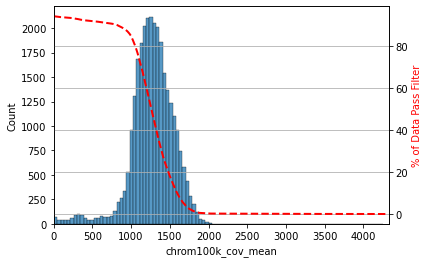

In [5]:
mcds.add_feature_cov_mean(var_dim=var_dim)

In [6]:
# filter by coverage - based on the distribution above
min_cov=500
max_cov=2000
mcds = mcds.filter_feature_by_cov_mean(
    min_cov=min_cov,  # minimum coverage
    max_cov=max_cov  # Maximum coverage
)

# remove blacklist regions
mcds = mcds.remove_black_list_region(
    black_list_path,
    f=black_list_fraction  # Features having overlap > f with any black list region will be removed.
)

# remove chromosomes
mcds = mcds.remove_chromosome(exclude_chromosome)

Before cov mean filter: 31137 chrom100k
 After cov mean filter: 28566 chrom100k 91.7%
722 chrom100k features removed due to overlapping (bedtools intersect -f 0.2) with black list regions.
1443 chrom100k features in ['chrX', 'chrY', 'chrM', 'chrL'] removed.


In [7]:
# Calculate Feature mC Fractions
mcds.add_mc_frac(
    var_dim=var_dim, 
    normalize_per_cell=True,  # after calculating mC frac, per cell normalize the matrix
    clip_norm_value=10  # clip outlier values above 10 to 10
)


In [8]:
## Downsample
downsample = 10000
total_cells = metadata.shape[0]
if downsample and total_cells > downsample:
    # make a downsampled mcds
    print(f'Downsample cells to {downsample} to calculate HVF.')
    downsample_cell_ids = metadata.sample(downsample, random_state=0).index
    mcds_sub = mcds.sel(
        {obs_dim: mcds.get_index(obs_dim).isin(downsample_cell_ids)})
else:
    mcds_sub = mcds
    
# load only the mC fraction matrix into memory so following steps is faster
# Only load into memory when you memory size is enough to handle your dataset
if load and (mcds_sub.get_index(obs_dim).size <= 20000):
    print('load')
    mcds_sub[f'{var_dim}_da_frac'].load()

Downsample cells to 10000 to calculate HVF.
load


/home/AD/jchien/.conda/envs/allcools_JC/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


In [9]:
## Highly Variable Feature(SVR: regression base)
mch_hvf = mcds_sub.calculate_hvf_svr(var_dim=var_dim,
                                 mc_type=mch_pattern,
                                 n_top_feature=n_top_feature,
                                 plot=False) 
mcds.coords[f'{var_dim}_{mch_pattern}_feature_select'] = mcds_sub.coords[f'{var_dim}_{mch_pattern}_feature_select']
mch_adata = mcds.get_adata(mc_type=mch_pattern,
                           var_dim=var_dim,
                           select_hvf=True)
mch_adata.write_h5ad(f'{output_dir}{CZIOI}_{var_dim}_mCH.HVF.h5ad')

mcg_hvf = mcds_sub.calculate_hvf_svr(var_dim=var_dim,
                                 mc_type=mcg_pattern,
                                 n_top_feature=n_top_feature,
                                 plot=False)
mcds.coords[f'{var_dim}_{mcg_pattern}_feature_select'] = mcds_sub.coords[f'{var_dim}_{mcg_pattern}_feature_select']
mcg_adata = mcds.get_adata(mc_type=mcg_pattern,
                           var_dim=var_dim,
                           select_hvf=True)
mcg_adata.write_h5ad(f'{output_dir}{CZIOI}_{var_dim}_mCG.HVF.h5ad')

Fitting SVR with gamma 0.0379, predicting feature dispersion using mc_frac_mean and cov_mean.
Total Feature Number:     26407
Highly Variable Feature:  20000 (75.7%)


/home/AD/jchien/.conda/envs/allcools_JC/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
... storing 'batch' as categorical
... storing 'Plate' as categorical
... storing 'Sample' as categorical
... storing 'chrom' as categorical


Fitting SVR with gamma 0.0379, predicting feature dispersion using mc_frac_mean and cov_mean.
Total Feature Number:     26407
Highly Variable Feature:  20000 (75.7%)


/home/AD/jchien/.conda/envs/allcools_JC/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
... storing 'batch' as categorical
... storing 'Plate' as categorical
... storing 'Sample' as categorical
... storing 'chrom' as categorical


31
Downsample PC matrix to 50000 cells to calculate significant PC components
49 components passed P cutoff of 0.1.
Changing adata.obsm['X_pca'] from shape (55447, 50) to (55447, 49)


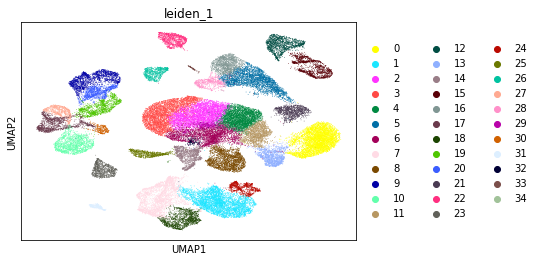

Found 35 clusters to compute feature enrichment score
Computing enrichment score
Computing enrichment score FDR-corrected P values
Selected 3400 unique features


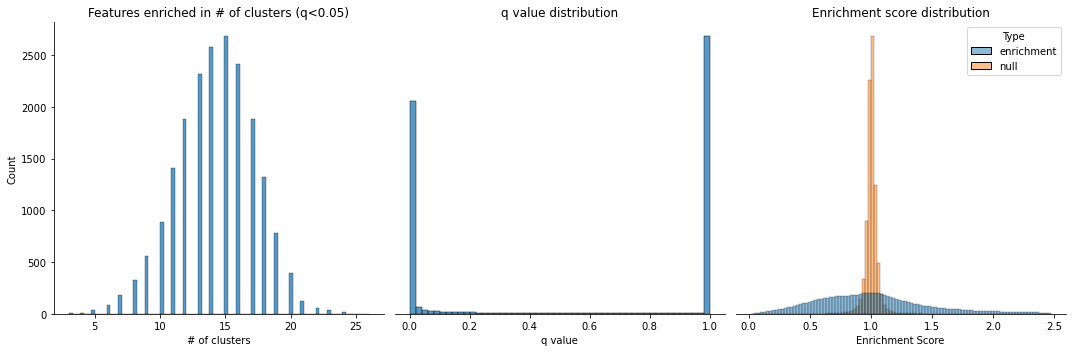

In [10]:
## Pre-clustering & Cluster Enriched Features (CEF)
if knn == -1:
    knn = max(15, int(np.log2(mch_adata.shape[0])*2))
print(knn)
top_n=200
alpha=0.05

#mCH
mch_adata.raw = mch_adata # put the unscaled matrix in adata.raw
log_scale(mch_adata)
sc.tl.pca(mch_adata)
significant_pc_test(mch_adata, p_cutoff=pc_cutoff, update=True)
sc.pp.neighbors(mch_adata, n_neighbors=knn)
sc.tl.leiden(mch_adata, resolution=resolution,key_added=cluster_col)
sc.tl.umap(mch_adata)
sc.pl.umap(mch_adata, color=cluster_col)
mch_adata = mch_adata.raw.to_adata() # return to unscaled X, CEF need to use the unscaled matrix
del mch_adata.uns['log']

cluster_enriched_features(mch_adata,
                          cluster_col=cluster_col,
                          top_n=top_n,
                          alpha=alpha,
                          stat_plot=True)


Downsample PC matrix to 50000 cells to calculate significant PC components
26 components passed P cutoff of 0.1.
Changing adata.obsm['X_pca'] from shape (55447, 50) to (55447, 26)


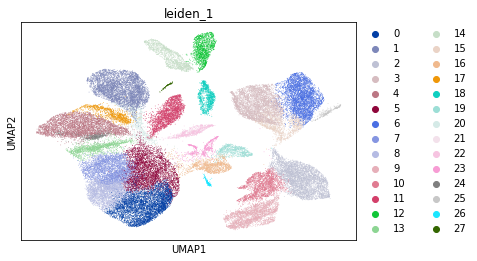

Found 28 clusters to compute feature enrichment score
Computing enrichment score
Computing enrichment score FDR-corrected P values
Selected 3180 unique features


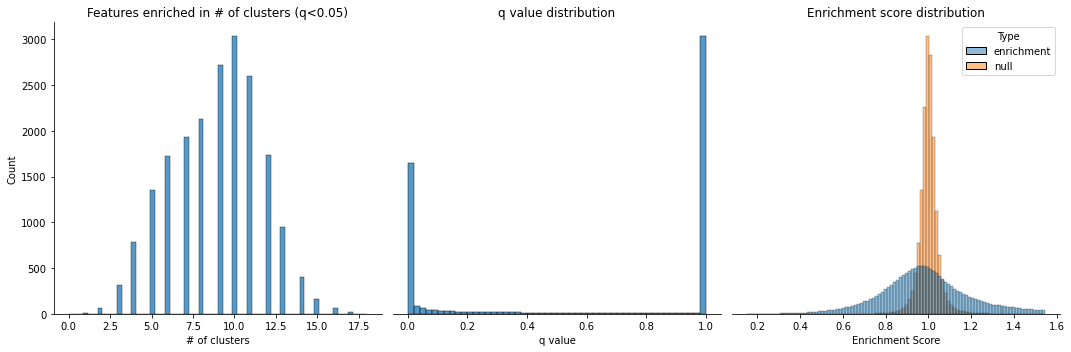

In [11]:
#mCG
mcg_adata.raw = mcg_adata # put the unscaled matrix in adata.raw
log_scale(mcg_adata)
sc.tl.pca(mcg_adata)
significant_pc_test(mcg_adata, p_cutoff=pc_cutoff, update=True)
sc.pp.neighbors(mcg_adata, n_neighbors=knn)
sc.tl.leiden(mcg_adata, resolution=resolution,key_added=cluster_col)
sc.tl.umap(mcg_adata)
sc.pl.umap(mcg_adata, color=cluster_col)
mcg_adata = mcg_adata.raw.to_adata() # return to unscaled X, CEF need to use the unscaled matrix
del mcg_adata.uns['log']

cluster_enriched_features(mcg_adata,
                          cluster_col=cluster_col,
                          top_n=top_n,
                          alpha=alpha,
                          stat_plot=True)

In [12]:
print('Using Cluster Enriched Features')
pre_cluster_name = cluster_col
mch_adata = mch_adata[:, mch_adata.var[f'{pre_cluster_name}_enriched_features']].copy()
mcg_adata = mcg_adata[:, mcg_adata.var[f'{pre_cluster_name}_enriched_features']].copy()
mch_scaler = log_scale(mch_adata)
mcg_scaler = log_scale(mcg_adata)

Using Cluster Enriched Features


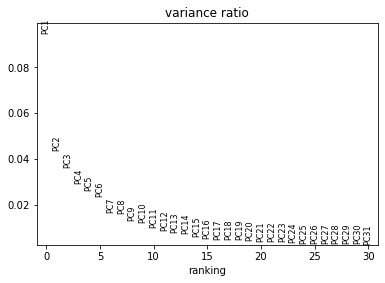

Downsample PC matrix to 50000 cells to calculate significant PC components
89 components passed P cutoff of 0.1.
Changing adata.obsm['X_pca'] from shape (55447, 100) to (55447, 89)


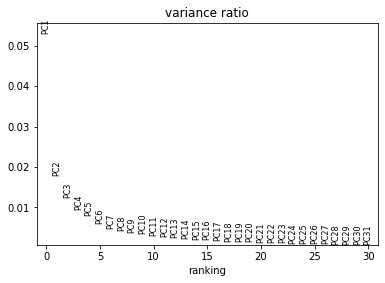

Downsample PC matrix to 50000 cells to calculate significant PC components
52 components passed P cutoff of 0.1.
Changing adata.obsm['X_pca'] from shape (55447, 100) to (55447, 52)


In [13]:
## PCA
balanced_pca(mch_adata, groups=pre_cluster_name)
sc.pl.pca_variance_ratio(mch_adata)
ch_n_components = significant_pc_test(mch_adata, p_cutoff=pc_cutoff)

balanced_pca(mcg_adata, groups=pre_cluster_name)
sc.pl.pca_variance_ratio(mcg_adata)
cg_n_components = significant_pc_test(mcg_adata, p_cutoff=pc_cutoff)

ch_pcs = mch_adata.obsm['X_pca'][:, :ch_n_components]
cg_pcs = mcg_adata.obsm['X_pca'][:, :cg_n_components]

# scale the PCs so CH and CG PCs has the same total var
cg_pcs = cg_pcs / cg_pcs.std()
ch_pcs = ch_pcs / ch_pcs.std()

# total_pcs
total_pcs = np.hstack([ch_pcs, cg_pcs])

# make a copy of adata, add new pcs
# this is suboptimal, will change this when adata can combine layer and X in the future
adata = mch_adata.copy() # use mCH as clustering
adata.obsm['X_pca'] = total_pcs #use total PCs to calculate distance
del adata.uns['pca']
del adata.varm['PCs']

In [14]:
#Manifold learning
def dump_embedding(adata, name, n_dim=2):
    # put manifold coordinates into adata.obs
    for i in range(n_dim):
        adata.obs[f'{name}_{i}'] = adata.obsm[f'X_{name}'][:, i]
    return adata

#tsne
tsne(adata,
     obsm='X_pca',
     metric='euclidean',
     exaggeration=-1,  # auto determined
     perplexity=30,
     n_jobs=-1)
adata = dump_embedding(adata, 'tsne')

#umap
sc.pp.neighbors(adata)
try:
    sc.tl.paga(adata, groups=pre_cluster_name,random_state=0)
    sc.pl.paga(adata, plot=False)
    sc.tl.umap(adata, init_pos='paga')
except:
    sc.tl.umap(adata)
dump_embedding(adata, 'umap')

AnnData object with n_obs × n_vars = 55447 × 3400
    obs: 'InputReadPairs', 'InputReadPairsBP', 'TrimmedReadPairs', 'R1WithAdapters', 'R1QualTrimBP', 'R1TrimmedReadsBP', 'R2WithAdapters', 'R2QualTrimBP', 'R2TrimmedReadsBP', 'DNAUniqueMappedReads', 'DNAUniqueMappingRate', 'DNAMultiMappedReads', 'DNAMultiMappingRate', 'DNAOverallMappingRate', 'RNAUniqueMappedReads', 'RNAUniqueMappingRate', 'RNAMultiMappedReads', 'RNAMultiMappingRate', 'RNAOverallMappingRate', 'DNAUniqueAlignFinalReads', 'DNAUniqueAlignDuplicatedReads', 'DNAUniqueAlignPCRDuplicationRate', 'DNAMultiAlignFinalReads', 'DNAMultiAlignDuplicatedReads', 'DNAMultiAlignPCRDuplicationRate', 'FinalDNAReads', 'SelectedDNAReadsRatio', 'FinalDNAReads.1', 'SelectedDNAReadsRatio.1', 'FinalRNAReads', 'SelectedRNAReadsRatio', 'mCCCCov', 'mCGCov', 'mCHCov', 'mCCCmC', 'mCGmC', 'mCHmC', 'mCCCFrac', 'mCGFrac', 'mCHFrac', 'AssignedRNAReads', 'UnassignedRNAReads', 'AssignedRNAReadsRate', 'batch', 'Plate', 'Sample', 'DNAReadsYield', 'RNAReadsYie

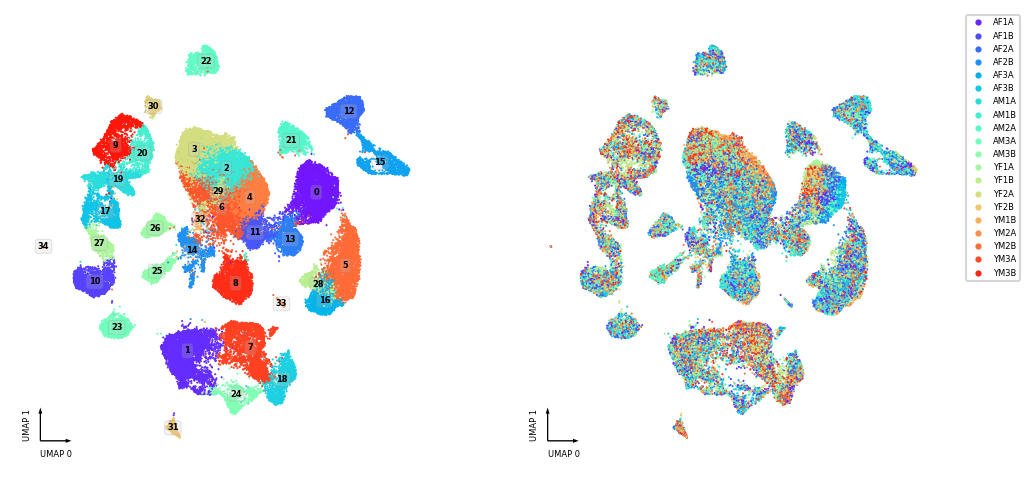

In [15]:
fig, ax = plt.subplots(1,2,figsize=(8,4), dpi=150)
_ = categorical_scatter(data=adata.obs,
                        ax=ax[0],
                        coord_base='umap',
                        hue=cluster_col,
                        text_anno=cluster_col,
                        s=1,
                        show_legend=False)
# _ = categorical_scatter(data=adata.obs,
#                         ax=ax[1],
#                         coord_base='tsne',
#                         hue=cluster_col,
#                         text_anno=cluster_col,
#                         s=1,
#                         show_legend=True)

_ = categorical_scatter(data=adata.obs,
                        ax=ax[1],
                        coord_base='umap',
                        hue='Sample',
                        s=1,
                        show_legend=True)


In [16]:
adata

AnnData object with n_obs × n_vars = 55447 × 3400
    obs: 'InputReadPairs', 'InputReadPairsBP', 'TrimmedReadPairs', 'R1WithAdapters', 'R1QualTrimBP', 'R1TrimmedReadsBP', 'R2WithAdapters', 'R2QualTrimBP', 'R2TrimmedReadsBP', 'DNAUniqueMappedReads', 'DNAUniqueMappingRate', 'DNAMultiMappedReads', 'DNAMultiMappingRate', 'DNAOverallMappingRate', 'RNAUniqueMappedReads', 'RNAUniqueMappingRate', 'RNAMultiMappedReads', 'RNAMultiMappingRate', 'RNAOverallMappingRate', 'DNAUniqueAlignFinalReads', 'DNAUniqueAlignDuplicatedReads', 'DNAUniqueAlignPCRDuplicationRate', 'DNAMultiAlignFinalReads', 'DNAMultiAlignDuplicatedReads', 'DNAMultiAlignPCRDuplicationRate', 'FinalDNAReads', 'SelectedDNAReadsRatio', 'FinalDNAReads.1', 'SelectedDNAReadsRatio.1', 'FinalRNAReads', 'SelectedRNAReadsRatio', 'mCCCCov', 'mCGCov', 'mCHCov', 'mCCCmC', 'mCGmC', 'mCHmC', 'mCCCFrac', 'mCGFrac', 'mCHFrac', 'AssignedRNAReads', 'UnassignedRNAReads', 'AssignedRNAReadsRate', 'batch', 'Plate', 'Sample', 'DNAReadsYield', 'RNAReadsYie

In [17]:
adata.write_h5ad(f'{output_dir}{CZIOI}.{var_dim}-clustering_CEF.h5ad')
adata.obs.to_csv(f'{output_dir}{CZIOI}.{var_dim}-clustering_CEF.csv.gz')

In [13]:
mcds['gene_da_frac'].sel(mc_type='CHN').load().sel().to_pandas()

/home/AD/jchien/.conda/envs/allcools_JC/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


gene,ENSG00000223972.5,ENSG00000227232.5,ENSG00000243485.5,ENSG00000237613.2,ENSG00000268020.3,ENSG00000240361.2,ENSG00000186092.6,ENSG00000238009.6,ENSG00000233750.3,ENSG00000268903.1,...,ENSG00000235857.1,ENSG00000237801.6_PAR_Y,ENSG00000237040.6_PAR_Y,ENSG00000124333.16_PAR_Y,ENSG00000228410.6_PAR_Y,ENSG00000223484.7_PAR_Y,ENSG00000124334.17_PAR_Y,ENSG00000270726.6_PAR_Y,ENSG00000182484.15_PAR_Y,ENSG00000227159.8_PAR_Y
cell,,,,,,,,,,,,,,,,,,,,,
13237_YM1B_1-1-K15-A1,0.490965,0.231491,1.0,1.000000,1.0,1.000000,1.000000,1.183347,1.110666,1.0,...,0.820833,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
13237_YM1B_1-1-K15-A2,1.000000,1.000000,1.0,1.000000,1.0,0.956940,1.000000,1.000000,1.000000,1.0,...,0.488694,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
13237_YM1B_1-1-K15-B13,1.000000,0.384791,1.0,1.000000,1.0,1.000000,1.000000,1.357808,1.000000,1.0,...,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
13237_YM1B_1-1-K15-B1,1.000000,0.525246,1.0,1.000000,1.0,0.442807,1.000000,0.637525,0.835911,1.0,...,0.572368,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
13237_YM1B_1-1-K15-B2,1.000000,1.000000,1.0,1.000000,1.0,1.122525,0.685216,1.309538,1.000000,1.0,...,0.813208,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13237_YM1B_8-6-G10-O23,1.000000,1.615657,1.0,1.000000,1.0,0.558401,2.108556,0.810034,0.423830,1.0,...,0.631865,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
13237_YM1B_8-6-G10-P11,1.000000,0.967577,1.0,1.000000,1.0,1.000000,1.000000,2.024694,1.000000,1.0,...,3.844719,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
13237_YM1B_8-6-G10-P12,1.000000,1.000000,1.0,1.000000,1.0,1.000000,1.000000,1.839739,1.000000,1.0,...,0.583175,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [ ]:
mcds.write_dataset(f'{output_dir}genes_frac.mcds', var_dims=var_dim)
use_gene_meta = gene_meta.loc[use_features]
use_gene_meta.to_csv(f'{output_dir}GeneMetadata.csv.gz')

# higher quality genes

In [32]:
gene_meta_path = '/cndd2/jchien/iGenome/gencodev37/gencode.v37.annotation.gene.flat.tsv.gz'
chrom_to_remove = ['chrM']

# CZIOI='CZIall'
# output_dir='/datasets/CZI_human_diversity/NOVAseq_hisat/'
metadata_path ='/datasets/CZI_human_diversity/NOVAseq_hisat/CZIall_CellMetadata.PassQC.csv.gz'
mcds_path_list =glob.glob('/datasets/CZI_human_diversity/NOVAseq_hisat/mcds/*.mcds/') 

obs_dim = 'cell'
var_dim = 'gene'

min_cov = 100 # min average coverage per cell

In [33]:
gene_meta = pd.read_csv(gene_meta_path, index_col='gene_id', sep='\t')
metadata = pd.read_csv(metadata_path, index_col=0)
total_cells = metadata.shape[0]
print(f'Metadata of {total_cells} cells')

Metadata of 55447 cells


In [34]:
#Filter genes by overlap and chromosomes
genes_to_skip = set()

# skip smaller genes mostly covered by a larger gene, e.g., a miRNA within a protein coding gene.
# F=0.9 means > 90% of gene_b is overlapped with gene_a, in this case, we only keep gene_a for DMG test
gene_bed = pybedtools.BedTool.from_dataframe(
    gene_meta.reset_index()[['chrom', 'start', 'end', 'gene_id']])
mapped_bam = gene_bed.map(b=gene_bed, c=4, o='distinct', F=0.9)
for _, (*_, gene_a, gene_b_str) in mapped_bam.to_dataframe().iterrows():
    for gene_b in gene_b_str.split(','):
        if gene_b != gene_a:
            genes_to_skip.add(gene_b)

# remove certain chromosomes
genes_to_skip |= set(gene_meta.index[gene_meta['chrom'].isin(chrom_to_remove)])
use_features = gene_meta.index[~gene_meta.index.isin(genes_to_skip)]
print(f'{use_features.size} features remained')

38955 features remained


In [36]:
##Filter genes by cell mean coverage
print(f'{use_features.size} features remained')
with dask.config.set(**{'array.slicing.split_large_chunks': False}):
#     still use all the cells to load MCDS
    mcds = MCDS.open(mcds_path_list[0:5], obs_dim=obs_dim,var_dim=var_dim,use_obs=metadata.index).sel({var_dim: use_features}) # to select cells: use_obs=metadata.index
mcds.add_feature_cov_mean(var_dim=var_dim)

feature_cov_mean = mcds.coords[f'{var_dim}_cov_mean'].to_pandas()
use_features &= feature_cov_mean[feature_cov_mean > min_cov].index
print(f'{use_features.size} features remained')
del mcds

In [ ]:
##Filter genes by cell mean coverage
print(f'{use_features.size} features remained')
with dask.config.set(**{'array.slicing.split_large_chunks': False}):
#     still use all the cells to load MCDS
    mcds = MCDS.open(mcds_path_list[5:10], obs_dim=obs_dim,var_dim=var_dim,use_obs=metadata.index).sel({var_dim: use_features}) # to select cells: use_obs=metadata.index
mcds.add_feature_cov_mean(var_dim=var_dim)

feature_cov_mean = mcds.coords[f'{var_dim}_cov_mean'].to_pandas()
use_features &= feature_cov_mean[feature_cov_mean > min_cov].index
print(f'{use_features.size} features remained')
del mcds

In [ ]:
##Filter genes by cell mean coverage
print(f'{use_features.size} features remained')
with dask.config.set(**{'array.slicing.split_large_chunks': False}):
#     still use all the cells to load MCDS
    mcds = MCDS.open(mcds_path_list[10:15], obs_dim=obs_dim,var_dim=var_dim,use_obs=metadata.index).sel({var_dim: use_features}) # to select cells: use_obs=metadata.index
mcds.add_feature_cov_mean(var_dim=var_dim)

feature_cov_mean = mcds.coords[f'{var_dim}_cov_mean'].to_pandas()
use_features &= feature_cov_mean[feature_cov_mean > min_cov].index
print(f'{use_features.size} features remained')
del mcds

In [ ]:
protein_coding=pd.read_csv('/cndd2/jchien/iGenome/gencodev37/gencode.v37.annotation.intragenic_proteincoding.bed.gz',header=None,sep='\t')[3]
use_features &= set(use_features).intersection(set(protein_coding))
print(f'{use_features.size} features remained')

In [ ]:
gene_meta.loc[use_features]

In [ ]:
use_gene_meta = gene_meta.loc[use_features]
use_gene_meta.to_csv(f'{output_dir}{CZIOI}_GeneMetadata_includeXY_cov100_proteincoding.csv.gz')